In [1]:
import os
from git import Repo
import dimcat as dc
from ms3 import __version__ as ms3_version
corpus_path = "~/ABC"
repo = Repo(corpus_path)
notebook_repo = Repo('.', search_parent_directories=True)
notebook_repo_path = notebook_repo.git.rev_parse("--show-toplevel")
print(f"Notebook repository '{os.path.basename(notebook_repo_path)}' @ {notebook_repo.commit().hexsha[:7]}")
print(f"Data repo '{os.path.basename(corpus_path)}' @ {repo.commit().hexsha[:7]}")
print(f"dimcat version {dc.__version__}")
print(f"ms3 version {ms3_version}")

Notebook repository 'dimcat' @ 8aeb127
Data repo 'ABC' @ 560802e
dimcat version 0.2.0.post1.dev64+gda0a036
ms3 version 1.0.2


# Working with Harmonic Annotations

In [2]:
import pandas as pd
import pitchtypes as pt # this requires the development branch of pitchtypes
import seaborn as sns
import logging
log = logging.getLogger()
log.setLevel(logging.WARNING)

## Load dataset

Use dimcat's `Dataset` class to load a dataset.
Each dataset consists of several corpora (here only `ABC`),
which in turn consist of several pieces (here `n01_op18-1_01`, `n01_op18-1_02`, etc.).

A `Dataset` has several representations of each piece (e.g. a list of chord labels or a list of notes) called *facets*.
Each facet is represented by a dataframe.

Corpora can be processed, e.g. slicing notes according to different criteria (see below).
The output of these operations is again a dataset with facets.

In [3]:
# this takes some time because it parses the original data, not the preprocessed tsv files
dataset = dc.Dataset()
dataset.load(corpus_path, parse_tsv=False, parse_scores=True) # make sure to parse directly from MuseScore files
dataset.data

[default|all]
All corpora
-----------
View: This view is called 'default'. It 
	- excludes fnames that are not contained in the metadata,
	- filters out file extensions requiring conversion (such as .xml), and
	- excludes review files and folders.

            has   active   scores        measures    notes expanded
       metadata     view detected parsed detected detected detected
corpus                                                             
ABC         yes  default       70     70       70       70       70

210/560 files are excluded from this view.

210 files have been excluded based on their subdir.

## Get notes

In [4]:
notes = dataset.get_facet("notes")
notes

mc   mn quarterbeats  duration_qb  \
corpus fname        interval                                               
ABC    n01op18-1_01 [0.0, 1.0)          1    1            0          1.0   
                    [0.0, 1.0)          1    1            0          1.0   
                    [0.0, 1.0)          1    1            0          1.0   
                    [0.0, 1.0)          1    1            0          1.0   
                    [1.0, 1.5)          1    1            1          0.5   
...                                   ...  ...          ...          ...   
       n16op135_04  [1146.0, 1147.0)  283  282         1146          1.0   
                    [1146.0, 1147.0)  283  282         1146          1.0   
                    [1146.0, 1147.0)  283  282         1146          1.0   
                    [1146.0, 1147.0)  283  282         1146          1.0   
                    [1146.0, 1147.0)  283  282         1146          1.0   

                                     mc_onset mn_onset timesig  staff  voice  \
corpus fname        interval                                                   
ABC    n01op18-1_01 [0.0, 1.0)              0        0     3/4      3      1   
                    [0.0, 1.0)              0        0     3/4      4      1   
                    [0.0, 1.0)              0        0     3/4      1      1   
                    [0.0, 1.0)              0        0     3/4      2      1   
                    [1.0, 1.5)            1/4      1/4     3/4      3      1   
...                                       ...      ...     ...    ...    ...   
       n16op135_04  [1146.0, 1147.0)        0        0     4/4      3      1   
                    [1146.0, 1147.0)        0        0     4/4      1      1   
                    [1146.0, 1147.0)        0        0     4/4      2      1   
                    [1146.0, 1147.0)        0        0     4/4      2      1   
                    [1146.0, 1147.0)        0        0     4/4      1      1   

                                     duration  ... nominal_duration scalar  \
corpus fname        interval                   ...                           
ABC    n01op18-1_01 [0.0, 1.0)            1/4  ...              1/4      1   
                    [0.0, 1.0)            1/4  ...              1/4      1   
                    [0.0, 1.0)            1/4  ...              1/4      1   
                    [0.0, 1.0)            1/4  ...              1/4      1   
                    [1.0, 1.5)            1/8  ...              1/8      1   
...                                       ...  ...              ...    ...   
       n16op135_04  [1146.0, 1147.0)      1/4  ...              1/4      1   
                    [1146.0, 1147.0)      1/4  ...              1/4      1   
                    [1146.0, 1147.0)      1/4  ...              1/4      1   
                    [1146.0, 1147.0)      1/4  ...              1/4      1   
                    [1146.0, 1147.0)      1/4  ...              1/4      1   

                                      tied  tpc  midi  name octave  chord_id  \
corpus fname        interval                                                   
ABC    n01op18-1_01 [0.0, 1.0)           1   -1    53    F3      3        12   
                    [0.0, 1.0)           1   -1    53    F3      3        18   
                    [0.0, 1.0)           1   -1    65    F4      4         0   
                    [0.0, 1.0)           1   -1    65    F4      4         6   
                    [1.0, 1.5)          -1   -1    53    F3      3        13   
...                                    ...  ...   ...   ...    ...       ...   
       n16op135_04  [1146.0, 1147.0)  <NA>   -1    53    F3      3      2731   
                    [1146.0, 1147.0)  <NA>    3    69    A4      4      2729   
                    [1146.0, 1147.0)  <NA>    3    69    A4      4      2730   
                    [1146.0, 1147.0)  <NA>   -1    77    F5      5      2730   
                    [1146.0, 1147.

## Example 1: Get pitches from dataframe and store them back

Translate pitch columns to actual pitches:

In [5]:
def get_pitches(tpc, midi):
    """
    Takes the tpc and midi columns of the notes df.
    Returns a SpelledPitchArray
    """
    pcs = pt.SpelledPitchClassArray(tpc)
    alterations = pcs.alteration()
    midi_base = midi - alterations
    octaves = (midi_base // 12) - 1
    return pt.SpelledPitchArray.from_independent(tpc, octaves)

pitches = get_pitches(notes['tpc'], notes['midi'])
pitches

asp(['F3', 'F3', 'F4', ..., 'A4', 'F5', 'F6'])

Assign back into dataframe:

In [6]:
notes['pitch_str'] = pitches.name() # a vector of names
notes['octave'] = pitches.octaves() # this makes it easier to convert back to a pitch array
notes

mc   mn quarterbeats  duration_qb  \
corpus fname        interval                                               
ABC    n01op18-1_01 [0.0, 1.0)          1    1            0          1.0   
                    [0.0, 1.0)          1    1            0          1.0   
                    [0.0, 1.0)          1    1            0          1.0   
                    [0.0, 1.0)          1    1            0          1.0   
                    [1.0, 1.5)          1    1            1          0.5   
...                                   ...  ...          ...          ...   
       n16op135_04  [1146.0, 1147.0)  283  282         1146          1.0   
                    [1146.0, 1147.0)  283  282         1146          1.0   
                    [1146.0, 1147.0)  283  282         1146          1.0   
                    [1146.0, 1147.0)  283  282         1146          1.0   
                    [1146.0, 1147.0)  283  282         1146          1.0   

                                     mc_onset mn_onset timesig  staff  voice  \
corpus fname        interval                                                   
ABC    n01op18-1_01 [0.0, 1.0)              0        0     3/4      3      1   
                    [0.0, 1.0)              0        0     3/4      4      1   
                    [0.0, 1.0)              0        0     3/4      1      1   
                    [0.0, 1.0)              0        0     3/4      2      1   
                    [1.0, 1.5)            1/4      1/4     3/4      3      1   
...                                       ...      ...     ...    ...    ...   
       n16op135_04  [1146.0, 1147.0)        0        0     4/4      3      1   
                    [1146.0, 1147.0)        0        0     4/4      1      1   
                    [1146.0, 1147.0)        0        0     4/4      2      1   
                    [1146.0, 1147.0)        0        0     4/4      2      1   
                    [1146.0, 1147.0)        0        0     4/4      1      1   

                                     duration  ... scalar  tied tpc  midi  \
corpus fname        interval                   ...                          
ABC    n01op18-1_01 [0.0, 1.0)            1/4  ...      1     1  -1    53   
                    [0.0, 1.0)            1/4  ...      1     1  -1    53   
                    [0.0, 1.0)            1/4  ...      1     1  -1    65   
                    [0.0, 1.0)            1/4  ...      1     1  -1    65   
                    [1.0, 1.5)            1/8  ...      1    -1  -1    53   
...                                       ...  ...    ...   ...  ..   ...   
       n16op135_04  [1146.0, 1147.0)      1/4  ...      1  <NA>  -1    53   
                    [1146.0, 1147.0)      1/4  ...      1  <NA>   3    69   
                    [1146.0, 1147.0)      1/4  ...      1  <NA>   3    69   
                    [1146.0, 1147.0)      1/4  ...      1  <NA>  -1    77   
                    [1146.0, 1147.0)      1/4  ...      1  <NA>  -1    89   

                                      name  octave chord_id  tremolo  volta  \
corpus fname        interval                                                  
ABC    n01op18-1_01 [0.0, 1.0)          F3       3       12      NaN   <NA>   
                    [0.0, 1.0)          F3       3       18      NaN   <NA>   
                    [0.0, 1.0)          F4       4        0      NaN   <NA>   
                    [0.0, 1.0)          F4       4        6      NaN   <NA>   
                    [1.0, 1.5)          F3       3       13      NaN   <NA>   
...                                    ...     ...      ...      ...    ...   
       n16op135_04  [1146.0, 1147.0)    F3       3     2731      NaN   <NA>   
                    [1146.0, 1147.0)    A4       4     2729      NaN   <NA>   
                    [1146.0, 1147.0)    A4       4     2730      NaN   <NA>   
                    [1146.0, 1147.0)    F5       5     2730      NaN   <NA>   
                    [1146.0, 1147.0)    F6       6     2729

## Example 2: Express all pitches relative to the key of the piece

We get the keys from the harmonic annotations:

In [7]:
labels = dataset.get_facet("expanded")
labels

DCML_HARMONY_INCOMPLETE_PEDAL_COLUMN_WARNING (13,) ms3.Parse.ABC.n10op74_04 -- /home/hentsche/miniconda3/envs/dimcat/lib/python3.10/site-packages/ms3/expand_dcml.py (line 145) expand_labels():
	propagate_pedal() failed with
	5 organ points started, 6 ended:
	     mc pedal   mc pedalend
	0    99    vi  100        ]
	1   101    #V  102        ]
	2   133     I  143        ]
	3   145     I  152        ]
	4   152     I  156        ]
	5  <NA>   NaN  157        ]
DCML_HARMONY_INCOMPLETE_PEDAL_COLUMN_WARNING (13,) ms3.Parse.ABC.n13op130_06 -- /home/hentsche/miniconda3/envs/dimcat/lib/python3.10/site-packages/ms3/expand_dcml.py (line 145) expand_labels():
	propagate_pedal() failed with
	13 organ points started, 14 ended:
	      mc pedal   mc pedalend
	0      3    vi    6        ]
	1     11    vi   13        ]
	2     20     V   21        ]
	3     22    ii   23        ]
	4     25     I   32        ]
	5     41     V   34        ]
	6     60     V   43        ]
	7     81     V   60        ]
	8    16

mc   mn quarterbeats  duration_qb  \
corpus fname        interval                                               
ABC    n01op18-1_01 [0.0, 3.0)          1    1            0          3.0   
                    [3.0, 6.0)          2    2            3          3.0   
                    [6.0, 9.0)          3    3            6          3.0   
                    [9.0, 15.0)         4    4            9          6.0   
                    [15.0, 18.0)        6    6           15          3.0   
...                                   ...  ...          ...          ...   
       n16op135_04  [1140.0, 1141.0)  281  280         1140          1.0   
                    [1141.0, 1142.0)  281  280         1141          1.0   
                    [1142.0, 1144.0)  282  281         1142          2.0   
                    [1144.0, 1146.0)  282  281         1144          2.0   
                    [1146.0, 1150.0)  283  282         1146          4.0   

                                     mc_onset mn_onset timesig  staff  voice  \
corpus fname        interval                                                   
ABC    n01op18-1_01 [0.0, 3.0)              0        0     3/4      4      1   
                    [3.0, 6.0)              0        0     3/4      4      1   
                    [6.0, 9.0)              0        0     3/4      4      1   
                    [9.0, 15.0)             0        0     3/4      4      1   
                    [15.0, 18.0)            0        0     3/4      4      1   
...                                       ...      ...     ...    ...    ...   
       n16op135_04  [1140.0, 1141.0)      1/2      1/2     4/4      4      1   
                    [1141.0, 1142.0)      3/4      3/4     4/4      4      1   
                    [1142.0, 1144.0)        0        0     4/4      4      1   
                    [1144.0, 1146.0)      1/2      1/2     4/4      4      1   
                    [1146.0, 1150.0)        0        0     4/4      4      1   

                                      label  ... chord_type  \
corpus fname        interval                 ...              
ABC    n01op18-1_01 [0.0, 3.0)          F.I  ...          M   
                    [3.0, 6.0)            V  ...          M   
                    [6.0, 9.0)            I  ...          M   
                    [9.0, 15.0)         IV6  ...          M   
                    [15.0, 18.0)        V65  ...        Mm7   
...                                     ...  ...        ...   
       n16op135_04  [1140.0, 1141.0)      I  ...          M   
                    [1141.0, 1142.0)     I6  ...          M   
                    [1142.0, 1144.0)  V(64)  ...          M   
                    [1144.0, 1146.0)     V7  ...        Mm7   
                    [1146.0, 1150.0)    I\\  ...          M   

                                     globalkey_is_minor localkey_is_minor  \
corpus fname        interval                                                
ABC    n01op18-1_01 [0.0, 3.0)                    False             False   
                    [3.0, 6.0)                    False             False   
                    [6.0, 9.0)                    False             False   
                    [9.0, 15.0)                   False             False   
                    [15.0, 18.0)                  False             False   
...                                                 ...               ...   
       n16op135_04  [1140.0, 1141.0)               True             False   
                    [1141.0, 1142.0)               True             False   
                    [1142.0, 1144.0)               True             False   
                    [1144.0, 1146.0)               True             False   
                    [1146.0, 1150.0)               True             False   

                                        chord_tones added_tones root  \
corpus fname        interval                                           
ABC    n01op18-1_01 [0.0, 3.0)            (

The global key is constrant throughout a piece, so we group by piece and take the first entry in each group.

In [8]:
keys = labels['globalkey'].groupby(['corpus', 'fname']).first()
keys

corpus  fname       
ABC     n01op18-1_01     F
        n01op18-1_02     d
        n01op18-1_03     F
        n01op18-1_04     F
        n02op18-2_01     G
                        ..
        n15op132_05      a
        n16op135_01      F
        n16op135_02      F
        n16op135_03     Db
        n16op135_04      f
Name: globalkey, Length: 70, dtype: object

In [9]:
keys[('ABC', 'n01op18-1_01')]

'F'

Now we group the dataframe by piece, get the key of each piece, and translate its pitches to intervals from the root (in octave 0).

In [10]:
def to_relative_pitch(grp):
    # find root
    index = grp.name
    root_name = keys[index]
    # the pitch's letter must be uppercase,
    # but the harmonic labels express minor keys using lowercase letters:
    root_name = root_name[0].upper() + root_name[1:]
    root = pt.SpelledPitchClass(root_name)
    
    # add new colums to the group: the key's root (name and tpc) and the relative pitch of each note
    grp = grp.copy()
    grp['global_root'] = str(root)
    grp['global_root_tpc'] = root.fifths()
    # load pitches from dataframe columns
    pitches = pt.SpelledPitchArray.from_independent(grp['tpc'], grp['octave'])
    # since the root is only a pitch class, we express pitches as interval classes.
    # alternatively, we could embed the root into pitch space (octave 0) and work with non-class intervals
    rel_pitches = pitches.pc() - root
    grp['rel_pitch'] = rel_pitches.name() # don't just assign rel_pitches, this will convert to a list of SpelledIntervalClass objects
    grp['rel_tic'] = rel_pitches.fifths()
    return grp

# group by piece and add columns
df_rel = notes.groupby(['corpus', 'fname'], axis="rows", sort=False, group_keys=False).apply(to_relative_pitch)
df_rel.to_csv('ABC_notes.csv.zip', sep='\t')
df_rel[['tpc', 'midi', 'pitch_str', 'global_root', 'global_root_tpc', 'rel_pitch', 'rel_tic']]

tpc  midi pitch_str global_root  \
corpus fname        interval                                            
ABC    n01op18-1_01 [0.0, 1.0)         -1    53        F3           F   
                    [0.0, 1.0)         -1    53        F3           F   
                    [0.0, 1.0)         -1    65        F4           F   
                    [0.0, 1.0)         -1    65        F4           F   
                    [1.0, 1.5)         -1    53        F3           F   
...                                   ...   ...       ...         ...   
       n16op135_04  [1146.0, 1147.0)   -1    53        F3           F   
                    [1146.0, 1147.0)    3    69        A4           F   
                    [1146.0, 1147.0)    3    69        A4           F   
                    [1146.0, 1147.0)   -1    77        F5           F   
                    [1146.0, 1147.0)   -1    89        F6           F   

                                      global_root_tpc rel_pitch  rel_tic  
corpus fname        interval                                              
ABC    n01op18-1_01 [0.0, 1.0)                     -1        P1        0  
                    [0.0, 1.0)                     -1        P1        0  
                    [0.0, 1.0)                     -1        P1        0  
                    [0.0, 1.0)                     -1        P1        0  
                    [1.0, 1.5)                     -1        P1        0  
...                                               ...       ...      ...  
       n16op135_04  [1146.0, 1147.0)               -1        P1        0  
                    [1146.0, 1147.0)               -1        M3        4  
                    [1146.0, 1147.0)               -1        M3        4  
                    [1146.0, 1147.0)               -1        P1        0  
                    [1146.0, 1147.0)               -1        P1        0  

[240132 rows x 7 columns]

Let's plot the distribution of untransposed tpcs vs the distribution of tpcs. You can see that the relative tpc is distributed more narrowly because we removed the variance that is due to the choice of key.

<AxesSubplot:xlabel='fifth', ylabel='Density'>

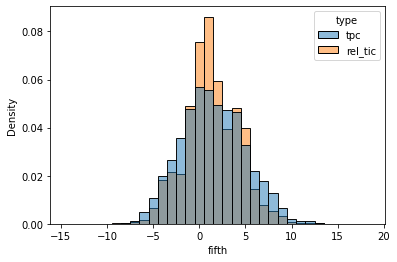

In [11]:
sns.histplot(data=df_rel[['tpc', 'rel_tic']].melt(var_name='type', value_name='fifth'),
             x='fifth',
             hue='type',
             stat='density',
             element='bars',
             discrete=True)